## taxonomy training

In [1]:
# Imports
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier, Pool, cv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import collections
import pickle
from sklearn.metrics import classification_report
from catboost.utils import get_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

### Load train and test file

In [2]:
%%time
train_pool = Pool("../data/taxonomy_dataset_train_subset_100000.tsv", 
               column_description="../data/columns_description.cd")
val_pool = Pool("../data/taxonomy_dataset_validation_subset_removed_low_freq_100000.tsv", 
               column_description="../data/columns_description.cd")
test_pool = Pool("../data/taxonomy_dataset_test_subset_removed_low_freq_100000.tsv", 
               column_description="../data/columns_description.cd")

CPU times: user 8min 21s, sys: 1min 15s, total: 9min 36s
Wall time: 5min 57s


### Data shape

In [3]:
train_pool.shape

(70012, 68509)

In [4]:
val_pool.shape

(19935, 68509)

In [5]:
test_pool.shape

(10051, 68509)

In [6]:
train_labels = train_pool.get_label()
label_count = collections.Counter(train_labels).most_common()
print("Number of classes:", len(label_count))
for label, count in label_count:
    print(count, '\t', label)

Number of classes: 156
9825 	 root:Host-associated:Human:Digestive system:Large intestine:Fecal
8993 	 root:Mixed
7146 	 root:Host-associated:Human:Digestive system:Oral
4148 	 root:Host-associated:Mammals:Digestive system
3187 	 root:Host-associated:Human:Reproductive system:Vagina
3035 	 root:Environmental:Aquatic:Marine
2967 	 root:Host-associated:Human:Skin
2518 	 root:Environmental:Terrestrial:Soil
1771 	 root:Host-associated:Plants:Rhizosphere
1559 	 root:Environmental:Aquatic:Freshwater:Lake
1459 	 root:Host-associated:Human:Digestive system:Oral:Saliva
1014 	 root:Host-associated:Mammals:Digestive system:Stomach:Rumen
997 	 root:Host-associated:Human:Respiratory system:Nasopharyngeal
970 	 root:Host-associated:Plants
943 	 root:Host-associated:Mammals:Digestive system:Large intestine:Fecal
925 	 root:Environmental:Aquatic:Marine:Sediment
910 	 root:Host-associated:Human
852 	 root:Environmental:Aquatic:Marine:Oceanic
831 	 root:Environmental:Aquatic
771 	 root:Host-associated:H

### Load trained model 

In [7]:
# Init the model
model = CatBoostClassifier(
            custom_loss=['Accuracy'],# this line needs to be commented out if using pretrained model
            random_seed=42,
            auto_class_weights = 'Balanced',
            task_type="GPU"
            )
trained_model = 'taxonomy_model_subset_100000.json'
# if os.path.exists(trained_model):
#     model.load_model(trained_model, format='json')

### Model training

In [8]:
# Train
model.fit(
    train_pool,
    eval_set=val_pool,
    logging_level='Verbose',
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.161508
0:	learn: 4.8541567	test: 4.8043714	best: 4.8043714 (0)	total: 443ms	remaining: 7m 22s
1:	learn: 4.6533115	test: 4.6256431	best: 4.6256431 (1)	total: 775ms	remaining: 6m 26s
2:	learn: 4.4670082	test: 4.4146897	best: 4.4146897 (2)	total: 1.12s	remaining: 6m 12s
3:	learn: 4.2671041	test: 4.2350146	best: 4.2350146 (3)	total: 1.45s	remaining: 6m 2s
4:	learn: 4.0586266	test: 3.9331485	best: 3.9331485 (4)	total: 1.78s	remaining: 5m 55s
5:	learn: 3.8586948	test: 3.6502603	best: 3.6502603 (5)	total: 2.33s	remaining: 6m 26s
6:	learn: 3.6605856	test: 3.4980063	best: 3.4980063 (6)	total: 2.67s	remaining: 6m 18s
7:	learn: 3.4757718	test: 3.3549963	best: 3.3549963 (7)	total: 3s	remaining: 6m 11s
8:	learn: 3.1748708	test: 3.0981873	best: 3.0981873 (8)	total: 3.33s	remaining: 6m 7s
9:	learn: 2.9640217	test: 2.8840012	best: 2.8840012 (9)	total: 3.68s	remaining: 6m 4s
10:	learn: 2.7783702	test: 2.6722663	best: 2.6722663 (10)	total: 4.01s	remaining: 6m
11:	learn: 2.5710977	

### Save model

In [9]:
# save model
model.save_model(trained_model,
           format="json",
           export_parameters=None,
           pool=train_pool)

### Prediction

In [10]:
model.score(test_pool)

0.07451994826385434

In [11]:
model.get_best_score()

{'learn': {'Accuracy:use_weights=true': 0.9767869224391621,
  'Accuracy:use_weights=false': 0.9013597668971034,
  'MultiClass': 2.431311085013375},
 'validation': {'Accuracy:use_weights=true': 0.9722664163362085,
  'Accuracy:use_weights=false': 0.8973664409330323,
  'MultiClass': 2.47232237171056}}

### Analysis

In [12]:
X_test = test_pool.get_features()
y_test = test_pool.get_label()
with open('../data/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)
predictions = model.predict(X_test)


### Precision and recall

In [13]:
precision_recall_fscore_support(y_test, predictions, average=None)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.


(array([0.125     , 1.        , 0.        , 0.        , 0.125     ,
        1.        , 1.        , 0.        , 1.        , 1.        ,
        1.        , 0.1       , 1.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 1.        , 1.        ,
        0.        , 1.        , 1.        , 1.        , 1.        ,
        0.        , 0.5       , 1.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 1.        , 0.5       , 1.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.5       , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 1.        , 0.        ,
        1.        , 0.        , 0.0010536 , 1.        , 0.        ,
        0.        , 1.        , 1.        , 0.25

In [14]:
precision_recall_fscore_support(y_test, predictions, average='micro')

(0.07451994826385434, 0.07451994826385434, 0.07451994826385434, None)

In [15]:
precision_recall_fscore_support(y_test, predictions, average='weighted')

(0.08008528053900954, 0.07451994826385434, 0.07125817575302058, None)

In [16]:
precision_recall_fscore_support(y_test, predictions, average=None, labels=model.classes_)

(array([0.125     , 1.        , 0.        , 0.        , 0.125     ,
        1.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 1.        , 0.        , 1.        , 0.1       ,
        0.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 1.        , 1.        ,
        0.        , 1.        , 1.        , 1.        , 1.        ,
        0.        , 0.5       , 1.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 1.        ,
        0.5       , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.5       ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 1.        , 0.  

### Confusion matrix

In [17]:
confusion_matrix_test = get_confusion_matrix(model, test_pool)
print(confusion_matrix_test.shape)
print(len(model.classes_))
confusion_matrix_test_pd = pd.DataFrame(data=np.log(confusion_matrix_test+0.001), columns=model.classes_, index=model.classes_)

(156, 156)
156


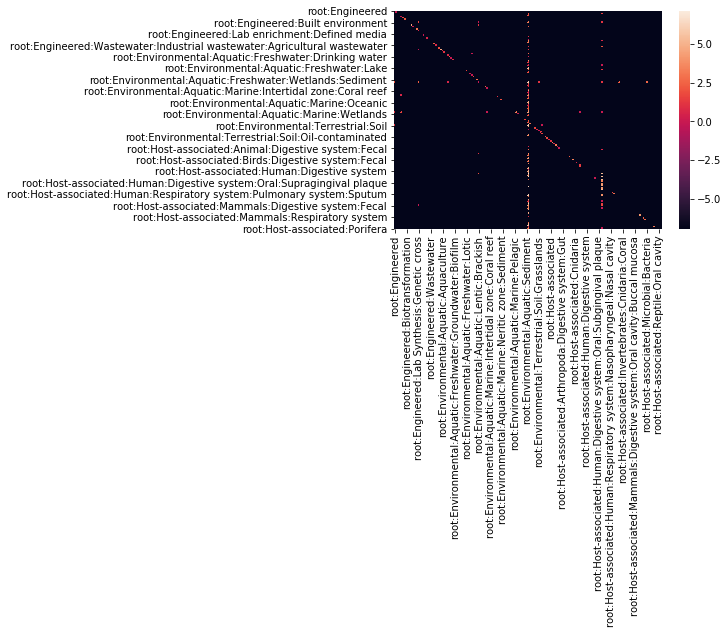

In [18]:
ax = sns.heatmap(confusion_matrix_test_pd)

### Feature importance

In [19]:
model_feature_importance = pd.Series(data=model.feature_importances_, index=model.feature_names_)
model_feature_importance

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
68504    0.0
68505    0.0
68506    0.0
68507    0.0
68508    0.0
Length: 68509, dtype: float64

In [ ]:
sorted_feature_importance = model_feature_importance[model_feature_importance.argsort()]
print(sorted_feature_importance)
plt.figure(figsize=(20,10))
plt.barh(sorted_feature_importance.values,
        sorted_feature_importance.index,
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

0        0.000000
45645    0.000000
45646    0.000000
45647    0.000000
45648    0.000000
           ...   
56578    1.548961
20440    1.548961
52961    1.747650
57825    2.462568
47208    5.036007
Length: 68509, dtype: float64


Text(0.5, 0, 'CatBoost Feature Importance')

### Shap values

In [ ]:
%%time
explainer_model = shap.TreeExplainer(model)

In [ ]:
shap_values = explainer_model.shap_values(X_test)

In [ ]:
%%time
shap.summary_plot(shap_values, X_test, feature_names = feature_names, max_display=50, class_names=model.classes_,show=False)
f = plt.gcf()
plt.savefig('shap_summary_first_50.png',bbox_inches='tight')